# Estimating CAPM

- This file can estimate CAPM for any firms that Yahoo has ticker data for.
- As written, it will estimate beta separately _for each calendar year_ in the date range you give it. But you can adjust it

- _Caveat: Yahoo Finance is more of a "quick and dirty" way to get return data. WRDS has more accurate return data._



In [12]:
# !pip install pandas_datareader
# !pip install yfinance

In [3]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr # you might need to install this (see above)
import yfinance as yf           # you might need to install this (see above)
from datetime import datetime
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load asset return data 

Load your stock returns. This file uses yahoo finance.
The returns don't even have to be firms! They can be any asset. (Portfolios, mutual funds, crypto, …)

In [52]:
# choose your firms and years 
stocks = ['SPY']
start  = datetime(2004, 1, 1)
end    = datetime(2023, 12, 31)

In [53]:
stocks

['SPY']

In [55]:
# download stock prices 
# here, from yahoo: not my fav source, but quick. 
# we need to do some data manipulation to get the data ready 
stock_prices         = yf.download(stocks, start , end)
stock_prices.index   = stock_prices.index.tz_localize(None)      # change yf date format to match pdr
stock_prices         = stock_prices.filter(like='Adj Close')     # reduce to just columns with this in the name
if len(stocks) > 1:
    stock_prices.columns = stock_prices.columns.get_level_values(1)  # tickers as col names, works no matter order of tics
else:
    stock_prices.columns = stocks
# stock_prices # uncomment to print and see

[*********************100%%**********************]  1 of 1 completed


In [56]:
# this is wide data... so if we want to create a new variable, 
# then we have to do it once for each firm...
# what if we have 1000 firms? seems tough to do...
# make long/tidy:
stock_prices = stock_prices.stack().swaplevel().sort_index().reset_index()
stock_prices.columns = ['Firm','Date','Adj Close']
stock_prices # print - now that is formatted nicely, like CRSP! 

,Firm,Date,Adj Close
0,SPY,2004-01-02,75.865784
1,SPY,2004-01-05,76.691078
2,SPY,2004-01-06,76.766106
3,SPY,2004-01-07,77.025284
4,SPY,2004-01-08,77.332222
...,...,...,...
5028,SPY,2023-12-22,473.649994
5029,SPY,2023-12-26,475.649994
5030,SPY,2023-12-27,476.510010
5031,SPY,2023-12-28,476.690002


In [57]:
# add return var = pct_change() function compares to prior row
# EXCEPT: don't compare for first row of one firm with last row of prior firm!
# MAKE SURE YOU CREATE THE VARIABLES WITHIN EACH FIRM - use groupby
stock_prices['ret'] = stock_prices.groupby('Firm')['Adj Close'].pct_change()
stock_prices['ret'] = stock_prices['ret'] *100 # convert to p.p. 

stock_prices['Year']=stock_prices['Date'].dt.year # add year column

In [60]:
stock_prices = stock_prices.dropna(subset = ['ret'])

In [78]:
df2 = stock_prices.copy()
df2['outlier'] = 1*(abs(df2['ret']) >= 3)
df2['ret'] = df2['ret'].clip(lower=-3.01, upper=3.01)
df2.describe()

,Date,Adj Close,ret,Year,outlier
count,5032,5032.000000,5032.000000,5032.000000,5032.000000
mean,2013-12-31 13:37:35.007949056,187.941150,0.047071,2013.498410,0.027027
min,2004-01-05 00:00:00,51.179268,-3.010000,2004.000000,0.000000
25%,2009-01-01 12:00:00,93.402281,-0.401613,2008.750000,0.000000
50%,2014-01-01 00:00:00,150.245674,0.069995,2013.500000,0.000000
75%,2018-12-31 12:00:00,256.579338,0.577087,2018.250000,0.000000
max,2023-12-29 00:00:00,476.690002,3.010000,2023.000000,1.000000
std,NaN,115.441432,1.012902,5.764441,0.162178


In [79]:
df2 .describe()

,Date,Adj Close,ret,Year,outlier
count,5032,5032.000000,5032.000000,5032.000000,5032.000000
mean,2013-12-31 13:37:35.007949056,187.941150,0.047071,2013.498410,0.027027
min,2004-01-05 00:00:00,51.179268,-3.010000,2004.000000,0.000000
25%,2009-01-01 12:00:00,93.402281,-0.401613,2008.750000,0.000000
50%,2014-01-01 00:00:00,150.245674,0.069995,2013.500000,0.000000
75%,2018-12-31 12:00:00,256.579338,0.577087,2018.250000,0.000000
max,2023-12-29 00:00:00,476.690002,3.010000,2023.000000,1.000000
std,NaN,115.441432,1.012902,5.764441,0.162178


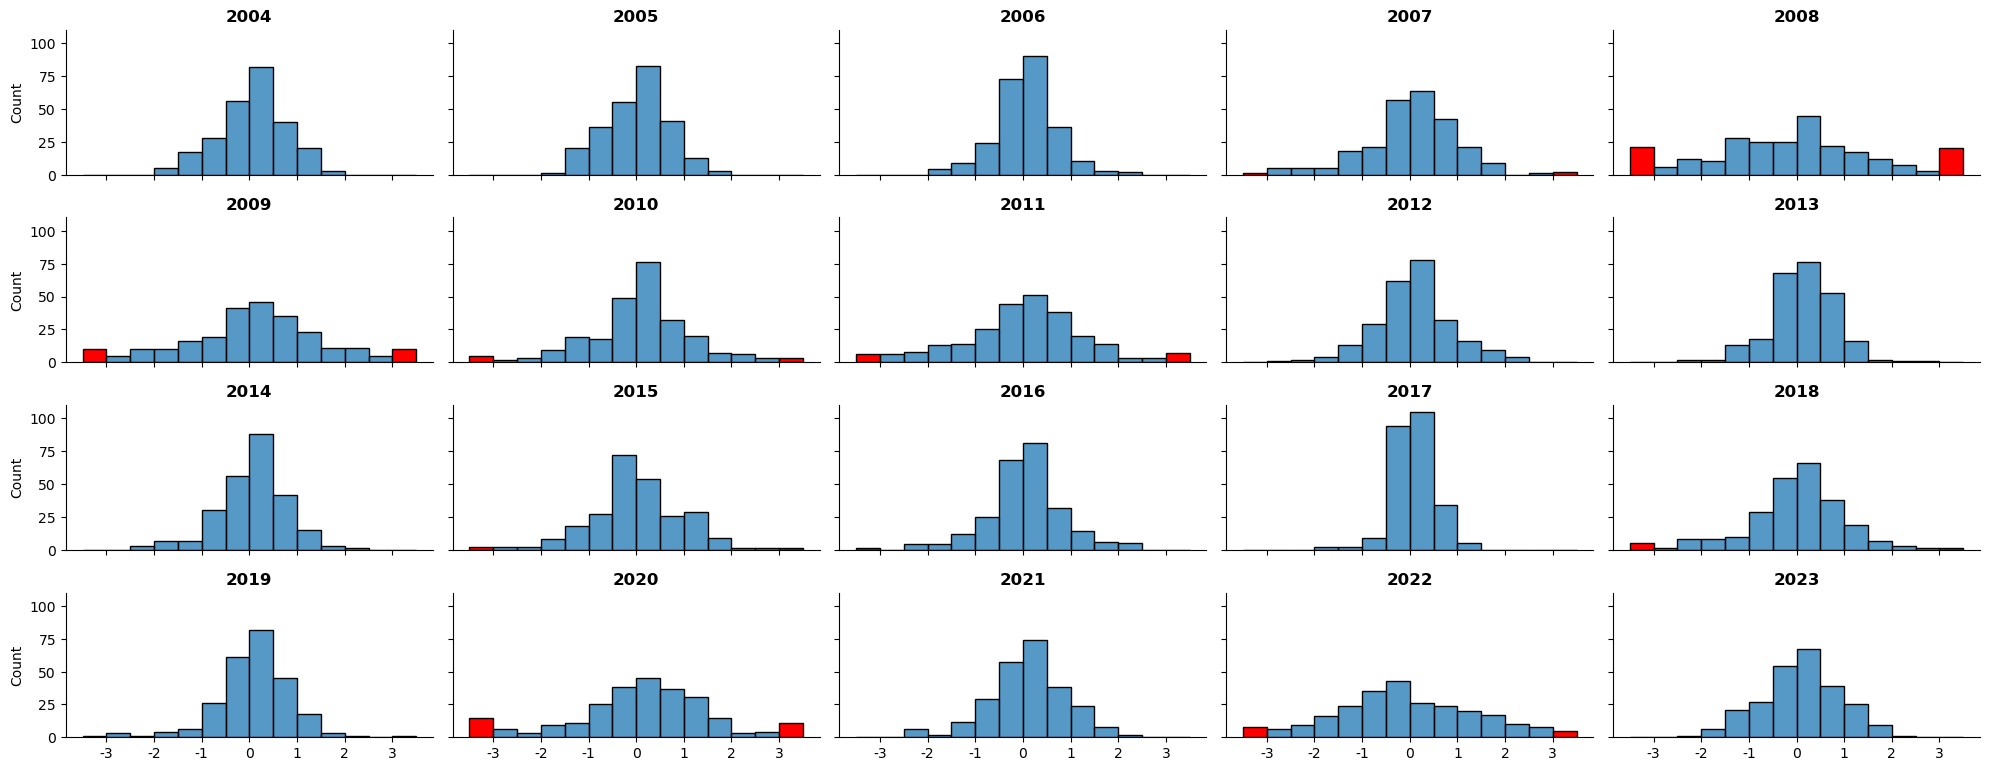

In [90]:
g = sns.FacetGrid(df2, col="Year",col_wrap=5 , height=2,aspect=2)
g.map(sns.histplot,"ret", binwidth=.5, binrange=(-3.5,3.5))

# alt vrs of above 2 rows
# g = sns.displot(data=df2,x='ret',col='Year',col_wrap=5, binwidth=.5, binrange=(-3.5,3.5), height=2,aspect=2)

for ax in g.axes.flatten():
    
    ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
    ax.set_xticklabels([-3, -2, -1, 0, 1, 2, 3])
    
    title = ax.get_title()
    ax.set_title(title[-4:], fontweight='bold')
    ax.set_xlabel("")
    
    for bar in ax.patches:
        if abs(bar.get_center()[0] ) >= 3:
            bar.set_facecolor('red')  # Change color to red


In [11]:
(
    assets_and_factors # grab the data
    
    # Two things before the regressions:
    # 1. need a year variable (to group on)
    # 2. the market returns in FF are excess returns, so 
    #    our stock returns need to be excess as well
    .assign(year = assets_and_factors.Date.dt.year,
            ret_excess = assets_and_factors.ret - assets_and_factors.RF)
    
    # ok, run the regs, so easy!
    .groupby(['Firm','year']).apply(reg_in_groupby,formula='ret_excess ~ mkt_excess')
    
    # and clean up - with better var names
    .rename(columns={'Intercept':'alpha','mkt_excess':'beta'})
    .reset_index()
)

,Firm,year,alpha,beta
0,AAPL,2016,-0.001081,0.965623
1,MSFT,2016,0.000690,1.166076
2,SBUX,2016,-0.056862,0.848163
